In [304]:
import pandas as pd
import seaborn as sns

In [305]:
projects_df = pd.read_csv("./raw_data/Projects.csv")
over_df, under_df = pd.DataFrame(), pd.DataFrame()
quarters = ["2020", "1Q20", "2Q20", "3Q20", "2021", "1Q21", "2Q21", "3Q21", "2022", "1Q22", "2Q22", "3Q22", "2023"]

In [306]:
over_df["actual"] = pd.to_datetime(projects_df["actualStartDate"])
over_df["planned"] = pd.to_datetime(projects_df["plannedStartDate"])
over_df = over_df.dropna()

In [312]:
over_df["year"] = over_df["actual"].dt.year
over_df["quarter"] = over_df["year"].astype(str) + "Q" + over_df["actual"].dt.quarter.astype(str)
over_df = over_df[over_df["year"] >= 2020]

over_df["difference"] = (over_df["planned"] - over_df["actual"]).dt.days
over_df = over_df[over_df["difference"] > 0]
over_df = over_df[over_df["difference"] < 50]

/home/arish/dev/sam23-group14/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/arish/dev/sam23-group14/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0, 0.5, 'administrative duration (in days)')

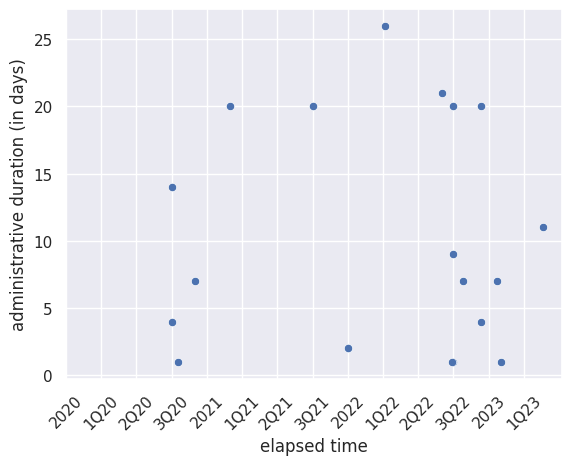

In [313]:
plt = sns.scatterplot(y="difference", x="actual", data=over_df)
plt.set_xticks(["2020-01-01", "2020-04-01", "2020-07-01", "2020-10-01", "2021-01-01", "2021-04-01", "2021-07-01", "2021-10-01", "2022-01-01", "2022-04-01", "2022-07-01", "2022-10-01", "2023-01-01", "2023-04-01"])
plt.set_xticklabels(["2020", "1Q20", "2Q20", "3Q20", "2021", "1Q21", "2Q21", "3Q21", "2022", "1Q22", "2Q22", "3Q22", "2023", "1Q23"], rotation=45)
plt.set_xlabel("elapsed time")
plt.set_ylabel("administrative duration (in days)")

In [330]:
overfitted_df = pd.DataFrame()
overfitted_df["actual"] = (pd.to_datetime(projects_df["actualEndDate"]) - pd.to_datetime(projects_df["actualStartDate"])).dt.days
overfitted_df["planned"] = (pd.to_datetime(projects_df["plannedEndDate"]) - pd.to_datetime(projects_df["plannedStartDate"])).dt.days
overfitted_df = overfitted_df.dropna()

/home/arish/dev/sam23-group14/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/arish/dev/sam23-group14/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='actual', ylabel='planned'>

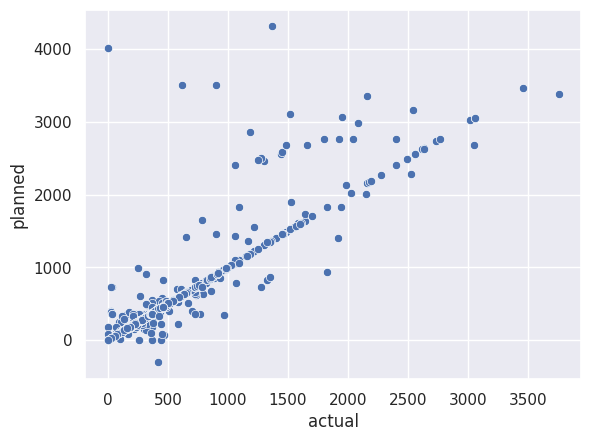

In [331]:
sns.scatterplot(x="actual", y="planned", data=overfitted_df)